In [ ]:
#pip install fastbook

In [2]:
# 이전까지...
from fastai.vision.all import *
from fastbook import *
import ipywidgets as widgets

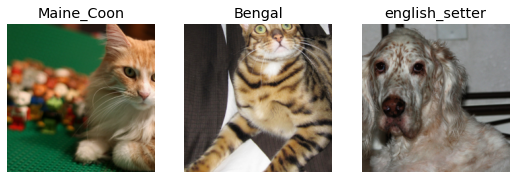

In [3]:
path= untar_data(URLs.PETS)

pets= DataBlock(blocks= (ImageBlock, CategoryBlock),
                get_items= get_image_files,
                splitter= RandomSplitter(seed= 42),
                get_y= using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                item_tfms= Resize(460),
                batch_tfms= aug_transforms(size=224, min_scale=0.75))
dls= pets.dataloaders(path/"images")

dls.show_batch(nrows=1, ncols=3)

In [4]:
learn= vision_learner(dls, resnet34, metrics= error_rate)
learn.fine_tune(2)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.528094,0.344702,0.112991,01:14


epoch,train_loss,valid_loss,error_rate,time
0,0.513919,0.335105,0.105548,01:14
1,0.311012,0.214778,0.069689,01:14


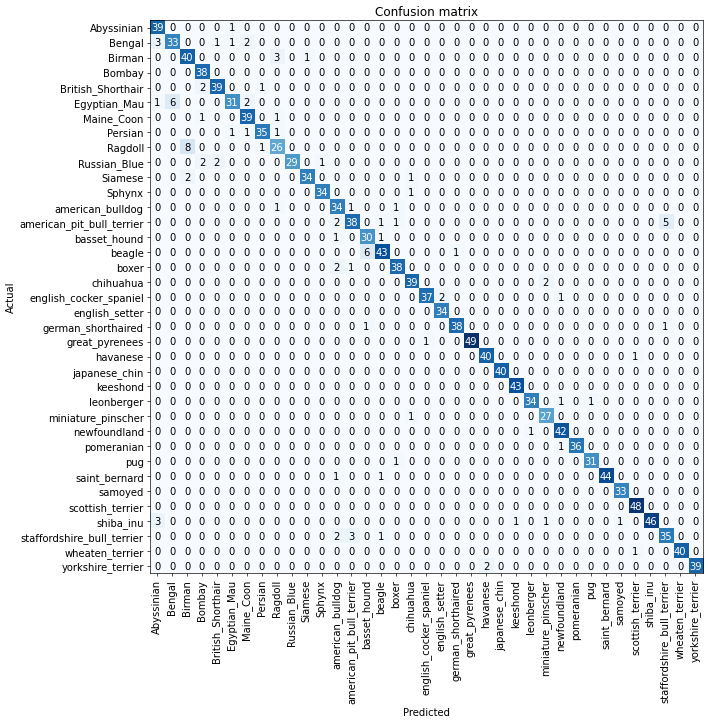

In [5]:
# 모델 해석
interp= ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

In [6]:
interp.most_confused(min_val=5) # min_val=5는 최소 5번 잘못 에측한 부분만 추출한다는 의미

[('Ragdoll', 'Birman', 8),
 ('Egyptian_Mau', 'Bengal', 6),
 ('beagle', 'basset_hound', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5)]

In [7]:
# 학습률 발견자
learn= vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr= 0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.591646,5.571169,0.498647,01:15


epoch,train_loss,valid_loss,error_rate,time
0,3.697031,2.439657,0.637348,01:19


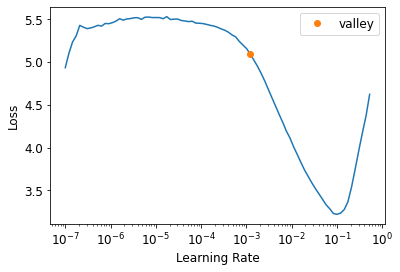

In [8]:
learn= vision_learner(dls, resnet34, metrics=error_rate)
lr_find= learn.lr_find() # 학습률 발견자

In [9]:
learn= vision_learner(dls, resnet34, metrics= error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.343903,0.339968,0.108254,01:13


epoch,train_loss,valid_loss,error_rate,time
0,0.563756,0.327369,0.101489,01:20
1,0.344118,0.247172,0.077131,01:34


epoch,train_loss,valid_loss,error_rate,time
0,1.100172,0.373808,0.110961,01:18
1,0.539978,0.244139,0.084574,01:25
2,0.337878,0.221063,0.066982,01:27


SuggestedLRs(valley=7.585775892948732e-05)

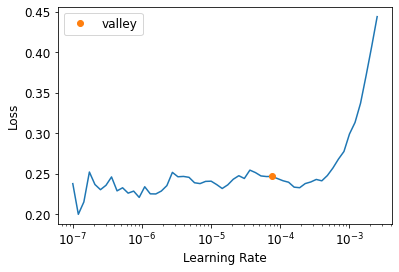

In [10]:
# 동결 해제, 전이학습, fine_tune의 세부내용
learn= vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

learn.unfreeze()

learn.lr_find()

In [11]:
learn.fit_one_cycle(6, lr_max= 1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.268198,0.211688,0.062246,01:36
1,0.254624,0.205073,0.060217,01:30
2,0.224289,0.198104,0.057510,01:25
3,0.227809,0.192864,0.058863,01:28
4,0.183019,0.194245,0.055480,01:33
5,0.180409,0.194005,0.054127,01:26


# 5.5.3 차별적 학습률
### 동결 해제 후에도
#### 사전 학습에서 형성된 가중치의 '품질'에 주의를 깊게 기울여야 한다.
##### ('사전 학습된 파라미터'를 위한 "최적의 학습률"이 '임의로 추가된 파라미터' 학습에서만큼 크다고 생각해서는 안된다. 그리고, 이는 조정한 후에도 마찬가지...)
### 이전 절의 후반부 내용('학습률 발견자'와 '차별적 학습률 소개'한 부분)을 보면,
#### 초기보다 후기 계층을 더 빠르게 미세 조정하는 편이 타당하다.
### 참고로, fastai는 차별적 학습률의 사용을 기본 접근법으로 채택한다.
#### 신경망의 초기 계층에는 작은 학습률을 사용하고,
#### 후기 계층에는 높은 학습률을 사용한다.
##### (simple is best)
### fastai는 파이썬의 slice 객체를 수용한다.
#### 학습률을 지정할 수 있는 모든 곳에서 slice 객체를 사용할 수 있다.

In [12]:
learn= vision_learner(dls, resnet34, metrics= error_rate)
# -- 이하 learn.fine_tune(3, 3e-3)과 동일한 내용
learn.fit_one_cycle(3, 3e-3) # 한 에포크 동안 추가된 계층의 임의 가중치만 갱신(학습)
learn.unfreeze() # 모든 계층의 동결을 해제
learn.fit_one_cycle(12, lr_max= slice(1e-6, 1e-4)) # 요청된 에포크 수만큼 학습을 진행.

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.147583,0.344900,0.120433,01:25
1,0.555845,0.226264,0.075101,01:26
2,0.325434,0.212228,0.067659,01:23


epoch,train_loss,valid_loss,error_rate,time
0,0.268147,0.206819,0.066982,01:28
1,0.260659,0.204121,0.070365,01:23
2,0.236407,0.203484,0.069689,01:31
3,0.209555,0.200253,0.064953,01:26
4,0.211415,0.189538,0.062246,01:26
5,0.193128,0.188034,0.060893,01:30
6,0.162422,0.184839,0.063599,01:15
7,0.156363,0.184627,0.061570,01:37
8,0.143153,0.187239,0.062923,01:33
9,0.134426,0.183764,0.061570,01:28


### .fit_one_cycle(12, lr_max= slice(1e-6, 1e-4))
#### * lr_max= slice(1e-6, 1e-4)를 통해 슬라이스 객체 수용을 확인했다. 초기 계층은 1e-6 학습률을, 다른 후기 계층들은 1e-6 학습률에서 1e-4 학습률 까지 일정하게 증가하여 설정된다.

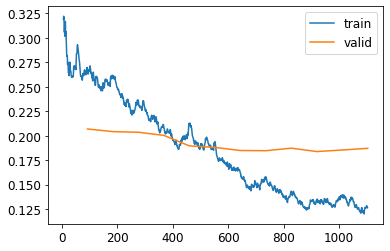

In [13]:
learn.recorder.plot_loss()

##### fastai 제공, 학습용과 검증용 데이터셋의 손실 그래프 그리는 기능.
#### 전체적으로 보았을 때, 학습용 데이터셋 손실이 계속해서 나아지는 모습이다.
### 하지만,
#### 때로는 나빠지는 모습을 보이기도 한다. 이러한 특성을 나타내는 부분이 '과적합이 발생하는 지점'이다.
##### * 과적합이 발생한다고 정확도가 떨어진다는 의미는 아님을 주의
##### ** 검증용 데이터셋 손실이 나빠지더라도 정확도는 계속해서 증가함을 알 수 있다.
### 우리가 알고싶은 것은 비즈니스 목적에 알맞게 고른 평가지표여야 한다. 손실이 아니다.

# 5.5.4 에포크 횟수 선택하기
### * 에포크 횟수 = 학습 진행 시간
#### 따라서, 얼마나 오랫동안 학습을 기다릴 수 있는지에 따라 에포크 횟수를 선정하는 것이 먼저이다.
### ** 최종 에포크에서도 여전히 모델이 개선될 여지가 있다 = 학습 시간이 충분하지 않았다.


# 5.5.5 더 깊은 구조
### 우리가 자주 사용하는 ResNet 모델은
#### * 18, 34, 50, 101, 152 등 여러 계층으로 구성된 버전이 존재한다.
#### ** 구조가 더 큰 ResNet 모델은 "항상" 더 나은 학습 손실을 얻게 한다.
#### 그렇다면, 구조가 더 크다고 무조건 좋을까?
### 정답은 No다.
#### 구조가 크다 -> 신경망이 더 깊다 -> GPU 메모리를 더 많이 요구한다. 따라서, "메모리 부족 오류"를 발생할 가능성이 커진다.
#### 이러한 오류를 피하기 위해서는 '배치 크기'를 줄여줘야만 한다. 즉, 한 번에 전달하는 이미지의 개수를 줄여야 한다.
#### 또한, 구조가 크다 -> 신경망이 더 깊다 -> 학습에 거치는 계층이 더 많다 -> 학습에 걸리는 시간이 증가한다. 이런 문제를 해결하기 위해 생겨난 기법중에는 '혼합 정밀도 학습(mixed-precision training)'이라는 기법이 있다. 또한, 현재는 NVIDIA GPU가 신경망 학습을 2~3배 가량 빠르게 해주는 "텐서 코어"라는 기능을 지원한다. 이는, 훨씬 적은 GPU 메모리를 요구한다.
### 그렇다면, fastai에서 텐서 코어 기능을 활성화하려면 어떻게 해야할까?

In [14]:
from fastai.callback.fp16 import *
learn= vision_learner(dls, resnet50, metrics= error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs= 3)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.280900,0.300948,0.108254,01:09
1,0.585095,0.291954,0.094723,01:11
2,0.425659,0.249350,0.075778,01:10


epoch,train_loss,valid_loss,error_rate,time
0,0.260131,0.224944,0.073748,01:15
1,0.336666,0.305349,0.088633,01:13
2,0.261166,0.267785,0.081191,01:10
3,0.147167,0.208284,0.062923,01:11
4,0.080849,0.190701,0.058863,01:16
5,0.056278,0.178252,0.058187,01:11


### fastai.callback.fp16
### .to_fp16()
#### * 반 정밀도 부동소수점
### .fine_tune(6, freeze_epochs= 3)
#### * freeze_epochs 는 인잣값으로 동결 상태에서의 학습 에포크 횟수를 지정할 수 있다. 그리고, 대부분의 데이터셋에 적절하도록 학습률을 자동으로 바꿔주기도 한다.

# 5.6 결론
### 우리가 5장에서 배운것들
#### 1) 이미지 데이터 준비하기
##### * 사전크기 조절
##### ** 데이터블록 요약
#### 2) 모델을 학습시키는 방법
##### * 학습률 발견자
##### ** 동결 해제
##### *** 차별적 학습률
##### **** 에포크 횟수 설정
##### ***** 더 깊은 구조 사용
#### 3) 교차 엔트로피 손실
### 교차 엔트로피 손실
#### * 거의 모든 "분류 모델'에서 사용"하므로 "반드시" 이해할 것.
#### ** 특히 입력, 출력.
##### ps. '모델 디버깅', '모델 상용화', '모델 정확도 개선'을 하려면 "모델의 활성과 손실"을 살펴보고 무슨일이 일어나는지, 왜 일어나는지를 이해해야만 한다. 손실 함수를 이해하지 못하면 작업을 올바르게 수행할 수 없다.